In this example, we will compare effectiveness of stop loss and trailing stop loss across multiple cryptocurrencies and time ranges. 

We will conduct in total 370,000 tests. First, we will pick and fetch 2 years of daily pricing data for 10 cryptocurrencies of main interest. For each one, we will split the entire history into 367 (overlapping) time ranges each 1 year long and select the first date of each range as a buy signal. For each such signal, we will test 100 different stop loss and trailing stop values with 1% increment. These will be our exit signals stored in separate variables. We will also generate random exit signals in our third variable to be able to compare effectiveness of stop loss with that of a random exit strategy. Finally, we will calculate performance of all strategies and compare them interactivelly. Thanks to vectorbt, such tests can be done in a matter of minutes. You can also change any of the parameters mentioned above at the beginning of the notebook.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
import itertools
import yfinance as yf
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import ipywidgets

In [3]:
# Define your params here
seed = 42
asset_names = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 
    'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD']
price_name = 'Open'

history_len = timedelta(days=365*2)
end_date = datetime.now()
start_date = end_date - history_len
time_window = timedelta(days=365) # length of a time window
freq = '1D'

stops = np.arange(0, 1, 0.01) # in %

vbt.defaults.portfolio['init_cash'] = 100. # in $
vbt.defaults.portfolio['fees'] = 0.0025 # in %
vbt.defaults.portfolio['slippage'] = 0.0025 # in %

print(len(asset_names) * (history_len.days - time_window.days), 'experiments per stop value')
print(len(stops), 'stop values per stop type')
print(len(asset_names) * (history_len.days - time_window.days) * len(stops), 'experiments per stop type')

3650 experiments per stop value
100 stop values per stop type
365000 experiments per stop type


In [4]:
%%time
# Download data
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
asset_history = {k: yf.Ticker(k).history(start=start_date, end=end_date) for k in asset_names}
asset_history = {k: v[ohlcv_cols] for k, v in asset_history.items()}
asset_history = {k: v.astype(np.float64) for k, v in asset_history.items()}

for k, v in asset_history.items():
    print(k, v.shape)
    
print(asset_history['BTC-USD'].columns)

BTC-USD (730, 5)
ETH-USD (730, 5)
XRP-USD (730, 5)
BCH-USD (730, 5)
LTC-USD (730, 5)
BNB-USD (730, 5)
EOS-USD (730, 5)
XLM-USD (730, 5)
XMR-USD (730, 5)
ADA-USD (715, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
CPU times: user 767 ms, sys: 92.7 ms, total: 860 ms
Wall time: 3.03 s


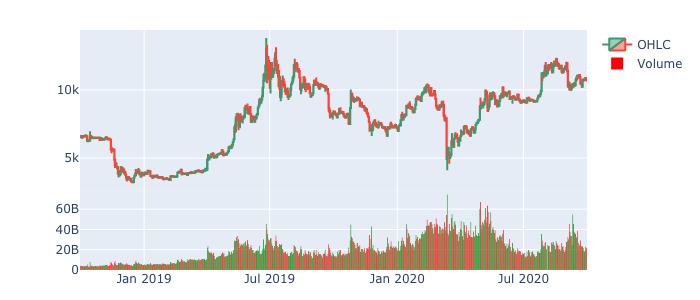

In [5]:
asset_history['BTC-USD'].vbt.ohlcv.plot().show_png()

In [6]:
%%time
# Stack all dfs along each column
price = pd.concat(map(lambda x: x[price_name], asset_history.values()), axis=1)
price.columns = pd.Index(asset_history.keys(), name='asset_name')

print(price.shape)
print(price.columns) # number of stocks

(730, 10)
Index(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD',
       'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'],
      dtype='object', name='asset_name')
CPU times: user 10.1 ms, sys: 3.68 ms, total: 13.8 ms
Wall time: 15 ms


In [7]:
%%time
# Split the whole time period into time ranges
price = price.vbt.split_into_ranges(range_len=time_window.days)
    
print(price.shape)
print(price.columns) # number of stocks x number of ranges

(365, 3660)
MultiIndex([('BTC-USD', '2018-10-01', '2019-09-30'),
            ('BTC-USD', '2018-10-02', '2019-10-01'),
            ('BTC-USD', '2018-10-03', '2019-10-02'),
            ('BTC-USD', '2018-10-04', '2019-10-03'),
            ('BTC-USD', '2018-10-05', '2019-10-04'),
            ('BTC-USD', '2018-10-06', '2019-10-05'),
            ('BTC-USD', '2018-10-07', '2019-10-06'),
            ('BTC-USD', '2018-10-08', '2019-10-07'),
            ('BTC-USD', '2018-10-09', '2019-10-08'),
            ('BTC-USD', '2018-10-10', '2019-10-09'),
            ...
            ('ADA-USD', '2019-09-22', '2020-09-21'),
            ('ADA-USD', '2019-09-23', '2020-09-22'),
            ('ADA-USD', '2019-09-24', '2020-09-23'),
            ('ADA-USD', '2019-09-25', '2020-09-24'),
            ('ADA-USD', '2019-09-26', '2020-09-25'),
            ('ADA-USD', '2019-09-27', '2020-09-26'),
            ('ADA-USD', '2019-09-28', '2020-09-27'),
            ('ADA-USD', '2019-09-29', '2020-09-28'),
            ('ADA-

In [8]:
%%time
# Pick one entry signal at the beginning of each time range
entries = pd.DataFrame.vbt.signals.empty(price.shape)
entries.iloc[0, :] = True

# Right now our rand signals have no meaningful columns
entries.columns = price.columns

print(entries.shape)
print(entries.columns)

(365, 3660)
MultiIndex([('BTC-USD', '2018-10-01', '2019-09-30'),
            ('BTC-USD', '2018-10-02', '2019-10-01'),
            ('BTC-USD', '2018-10-03', '2019-10-02'),
            ('BTC-USD', '2018-10-04', '2019-10-03'),
            ('BTC-USD', '2018-10-05', '2019-10-04'),
            ('BTC-USD', '2018-10-06', '2019-10-05'),
            ('BTC-USD', '2018-10-07', '2019-10-06'),
            ('BTC-USD', '2018-10-08', '2019-10-07'),
            ('BTC-USD', '2018-10-09', '2019-10-08'),
            ('BTC-USD', '2018-10-10', '2019-10-09'),
            ...
            ('ADA-USD', '2019-09-22', '2020-09-21'),
            ('ADA-USD', '2019-09-23', '2020-09-22'),
            ('ADA-USD', '2019-09-24', '2020-09-23'),
            ('ADA-USD', '2019-09-25', '2020-09-24'),
            ('ADA-USD', '2019-09-26', '2020-09-25'),
            ('ADA-USD', '2019-09-27', '2020-09-26'),
            ('ADA-USD', '2019-09-28', '2020-09-27'),
            ('ADA-USD', '2019-09-29', '2020-09-28'),
            ('ADA-

In [9]:
# Pick one exit signal at the end of each time range
exits = pd.DataFrame.vbt.signals.empty_like(entries)
exits.iloc[-1, :] = True

print(exits.shape)
print(exits.columns)

(365, 3660)
MultiIndex([('BTC-USD', '2018-10-01', '2019-09-30'),
            ('BTC-USD', '2018-10-02', '2019-10-01'),
            ('BTC-USD', '2018-10-03', '2019-10-02'),
            ('BTC-USD', '2018-10-04', '2019-10-03'),
            ('BTC-USD', '2018-10-05', '2019-10-04'),
            ('BTC-USD', '2018-10-06', '2019-10-05'),
            ('BTC-USD', '2018-10-07', '2019-10-06'),
            ('BTC-USD', '2018-10-08', '2019-10-07'),
            ('BTC-USD', '2018-10-09', '2019-10-08'),
            ('BTC-USD', '2018-10-10', '2019-10-09'),
            ...
            ('ADA-USD', '2019-09-22', '2020-09-21'),
            ('ADA-USD', '2019-09-23', '2020-09-22'),
            ('ADA-USD', '2019-09-24', '2020-09-23'),
            ('ADA-USD', '2019-09-25', '2020-09-24'),
            ('ADA-USD', '2019-09-26', '2020-09-25'),
            ('ADA-USD', '2019-09-27', '2020-09-26'),
            ('ADA-USD', '2019-09-28', '2020-09-27'),
            ('ADA-USD', '2019-09-29', '2020-09-28'),
            ('ADA-

In [10]:
%%time
# Calculate stop loss exits
stop_loss_exits = entries.vbt.signals.generate_stop_loss_exits(price, stops)
trail_stop_exits = entries.vbt.signals.generate_stop_loss_exits(price, stops, trailing=True)

print(stop_loss_exits.shape, trail_stop_exits.shape)
print(stop_loss_exits.columns)

# Update the number of columns to match those of stop exits
entries = entries.vbt.tile(len(stops))
exits = exits.vbt.tile(len(stops))
price = price.vbt.tile(len(stops))

assert(stop_loss_exits.shape == entries.shape)
assert(stop_loss_exits.shape == price.shape)

(365, 366000) (365, 366000)
MultiIndex([( 0.0, 'BTC-USD', '2018-10-01', '2019-09-30'),
            ( 0.0, 'BTC-USD', '2018-10-02', '2019-10-01'),
            ( 0.0, 'BTC-USD', '2018-10-03', '2019-10-02'),
            ( 0.0, 'BTC-USD', '2018-10-04', '2019-10-03'),
            ( 0.0, 'BTC-USD', '2018-10-05', '2019-10-04'),
            ( 0.0, 'BTC-USD', '2018-10-06', '2019-10-05'),
            ( 0.0, 'BTC-USD', '2018-10-07', '2019-10-06'),
            ( 0.0, 'BTC-USD', '2018-10-08', '2019-10-07'),
            ( 0.0, 'BTC-USD', '2018-10-09', '2019-10-08'),
            ( 0.0, 'BTC-USD', '2018-10-10', '2019-10-09'),
            ...
            (0.99, 'ADA-USD', '2019-09-22', '2020-09-21'),
            (0.99, 'ADA-USD', '2019-09-23', '2020-09-22'),
            (0.99, 'ADA-USD', '2019-09-24', '2020-09-23'),
            (0.99, 'ADA-USD', '2019-09-25', '2020-09-24'),
            (0.99, 'ADA-USD', '2019-09-26', '2020-09-25'),
            (0.99, 'ADA-USD', '2019-09-27', '2020-09-26'),
            

0.461775956284153
0.6721584699453552


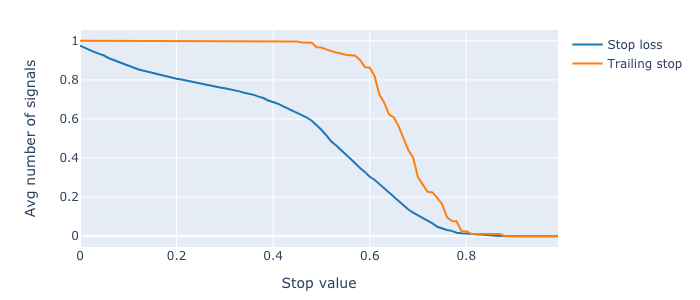

CPU times: user 972 ms, sys: 123 ms, total: 1.1 s
Wall time: 1.25 s


In [11]:
%%time
# How many exit signals our orders have generated?
print(stop_loss_exits.vbt.signals.num_signals().mean())
print(trail_stop_exits.vbt.signals.num_signals().mean())

stop_cols = stop_loss_exits.columns.get_level_values('stop_loss')

pd.DataFrame({
    'Stop loss': stop_loss_exits.vbt.signals.num_signals().groupby(stop_cols).mean(),
    'Trailing stop': trail_stop_exits.vbt.signals.num_signals().groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg number of signals').show_png()

In [12]:
# Combine exits with stop loss exits
stop_loss_exits = exits.vbt | stop_loss_exits.vbt
trail_stop_exits = exits.vbt | trail_stop_exits.vbt

print(stop_loss_exits.vbt.signals.num_signals().mean())
print(trail_stop_exits.vbt.signals.num_signals().mean())

1.4613852459016394
1.6717377049180329


In [13]:
# Select the first exit signal after each entry
stop_loss_exits = stop_loss_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
trail_stop_exits = trail_stop_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)

print(stop_loss_exits.vbt.signals.num_signals().mean())
print(trail_stop_exits.vbt.signals.num_signals().mean())

1.0
1.0


In [14]:
%%time
# To compare our stop loss orders with random trading strategy we need to place random exits
# After each entry signal place exactly one exit signal randomly
rand_exits = entries.vbt.signals.generate_random_exits(seed=seed)

assert(entries.shape == rand_exits.shape)

CPU times: user 3.38 s, sys: 63.2 ms, total: 3.44 s
Wall time: 3.46 s


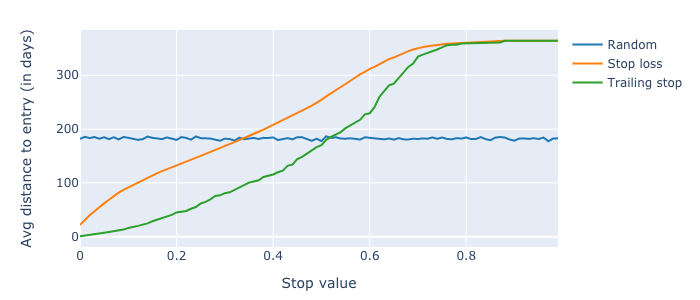

CPU times: user 4.79 s, sys: 125 ms, total: 4.92 s
Wall time: 5.07 s


In [15]:
%%time
# And what is the average distance to the entry signal?
@njit
def map_func_nb(col, entry_i, exit_i):
    return exit_i - entry_i # distance

@njit
def reduce_func_nb(col, a):
    return np.nanmean(a) # average of all distances

pd.DataFrame({
    'Random': entries.vbt.signals.map_reduce_between(
        other=rand_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Stop loss': entries.vbt.signals.map_reduce_between(
        other=stop_loss_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean(),
    'Trailing stop': entries.vbt.signals.map_reduce_between(
        other=trail_stop_exits, 
        map_func_nb=map_func_nb, 
        reduce_func_nb=reduce_func_nb).groupby(stop_cols).mean()
}).vbt.scatter(xaxis_title='Stop value', yaxis_title='Avg distance to entry (in days)').show_png()

In [16]:
%%time
# Calculate portfolio performance
# Performance of plain holding
hold_portfolio = vbt.Portfolio.from_signals(price, entries, exits, freq=freq)

hold_performance = hold_portfolio.total_return()

print(hold_performance.shape)
print(hold_performance.mean())

(366000,)
0.0603356906224215
CPU times: user 5.97 s, sys: 4.04 s, total: 10 s
Wall time: 11.9 s


In [17]:
%%time
# Performance of trading with random exits
rand_portfolio = vbt.Portfolio.from_signals(price, entries, rand_exits, freq=freq)

rand_performance = rand_portfolio.total_return()

print(rand_performance.shape)
print(rand_performance.mean())

(366000,)
0.11557652359440135
CPU times: user 6.12 s, sys: 5.23 s, total: 11.3 s
Wall time: 17.4 s


In [18]:
%%time
# Performance of trading with stop loss
stop_loss_portfolio = vbt.Portfolio.from_signals(price, entries, stop_loss_exits, freq=freq)

stop_loss_performance = stop_loss_portfolio.total_return()

print(stop_loss_performance.shape)
print(stop_loss_performance.mean())

(366000,)
-0.015527538672358548
CPU times: user 10.9 s, sys: 9.08 s, total: 20 s
Wall time: 27.2 s


In [19]:
%%time
# Performance of trading with trailing stop 
trail_stop_portfolio = vbt.Portfolio.from_signals(price, entries, trail_stop_exits, freq=freq)

trail_stop_performance = trail_stop_portfolio.total_return()

print(trail_stop_performance.shape)
print(trail_stop_performance.mean())

(366000,)
0.019077044365666502
CPU times: user 8.79 s, sys: 4.3 s, total: 13.1 s
Wall time: 14.7 s


In [20]:
# Plot performance of each strategy depending on the stop value and trend
# Trend is just the net return of this time period
net_return = (price.iloc[-1, :] - price.iloc[0, :]) / price.iloc[0, :]

# Widgets
assets = net_return.index.get_level_values('asset_name')
asset_dropdown = ipywidgets.Dropdown(
    options=['All'] + asset_names,
    value='All'
)
trend_dropdown = ipywidgets.Dropdown(
    options=['All', 'Positive', 'Negative'],
    value='All'
)
dates = net_return.index.get_level_values('range_start')
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates.unique(),
    index=(0, len(dates.unique())-1),
    orientation='horizontal',
    readout=False
)
date_range_label = ipywidgets.Label()
scatter_fig = vbt.plotting.create_scatter(
    trace_names=['Holding', 'Random', 'Stop Loss', 'Trailing Stop'],
    x_labels=stops, 
    xaxis_title='Stop value', 
    yaxis_title='Avg total return')
scatter_img = ipywidgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)

# Update function
def update_scatter(*args, **kwargs):
    trend = trend_dropdown.value
    asset = asset_dropdown.value
    date_range = date_range_slider.value
    
    # Build boolean mask based on selected values
    trend_mask = None
    asset_mask = None
    if trend == 'Positive':
        trend_mask = net_return.values > 0
    elif trend == 'Negative':
        trend_mask = net_return.values < 0
    if asset != 'All':
        asset_mask = assets == asset
    mask = (dates >= date_range[0]) & (dates <= date_range[1])
    if trend_mask is not None:
        mask = mask & trend_mask
    if asset_mask is not None:
        mask = mask & asset_mask
    
    # Update graph
    vbt.plotting.update_scatter_data(
        scatter_fig,
        np.asarray([
            hold_performance[mask].groupby(stop_cols[mask]).mean(),
            rand_performance[mask].groupby(stop_cols[mask]).mean(),
            stop_loss_performance[mask].groupby(stop_cols[mask]).mean(),
            trail_stop_performance[mask].groupby(stop_cols[mask]).mean()
        ]).transpose()
    )
    scatter_img.value = scatter_fig.to_image(format="png")
    
    # Update date range label
    date_range_label.value = '{:%d %b %Y} - {:%d %b %Y}'.format(date_range[0], date_range[1])

# Hooks
asset_dropdown.observe(update_scatter, names='value')
trend_dropdown.observe(update_scatter, names='value')
date_range_slider.observe(update_scatter, names='value')
update_scatter()

# Widget hierarchy
dashboard = ipywidgets.VBox([
    ipywidgets.HBox([
        ipywidgets.Label('Asset:'),
        asset_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Trend:'),
        trend_dropdown
    ]),
    ipywidgets.HBox([
        ipywidgets.Label('Date range:'),
        date_range_slider,
        date_range_label
    ]),
    scatter_img
])
dashboard

Amazing how similar is the picture for each asset!

In [21]:
dashboard.close() # after using, release memory and notebook metadata